In [2]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [3]:
from google.colab import files
uploaded = files.upload()

Saving pricedeathcor.csv to pricedeathcor.csv


#Preprocessing

In [105]:
def add_previous_transaction_data(df, artists):
  data_proc_prev = df.copy()
  colList = ["sale_year","sale_month","log_nom_price","paint_date","age","area"]
  prev_colList = []
  for col in colList:
    prev_string = "".join(("P_",col))
    data_proc_prev[prev_string] = 0


  for name in mergelist.name:
    for col in colList:
      prev_string = "".join(("P_",col))
      data_proc_prev.loc[data_proc_prev[name]==1,prev_string] = data_proc.loc[data_proc[name]==1,col].shift(1)
  
  #adds a column to indicate if there are NA values
  data_proc_prev["no_prev_sale"] = 0
  data_proc_prev["no_prev_sale"] = data_proc_prev['P_sale_year'].isna().apply(lambda x: 1 if x==True else 0)
  data_proc_prev = data_proc_prev.fillna(0)
      
  return data_proc_prev

In [179]:
data = pd.read_csv("pricedeathcor.csv",encoding= 'unicode_escape')
artists = data.artist.unique()
mergelist = np.empty([len(artists),3],dtype=object)
for i,artist in enumerate(artists):
  name, info = artist.split(" (") #splits of name from year data
  _,death = info.split("d. ") # splits off death data from birth
  death = death[:-1] #removes trailing parenthesis
  mergelist[i] = [artist, name, death]
mergelist = pd.DataFrame(mergelist,columns=["artist","name","death"])
data = data.merge(mergelist)
data.death = pd.to_numeric(data.death)

#drops data except for price estimates

top_houses = ["Christie's New York","Christie's London","Sotheby's New York","Sotheby's London",]
data = data[data.house.isin(top_houses)]
data = data.drop(["auction_name_lot","hammer","pdate","date","lot_no","curr","cpi","saleyear","omeana","larea","saleprice","american"],1)
medianPrice = np.asarray((data.low_est.values + data.high_est.values)/2)
salePrice = np.asarray(data.nomprice.values)
data = data.drop(["low_est","high_est"],axis=1)

#subtracts year of death of family member from year of death to make their magnitude more significant
relations = ["father",	"mother",	"wife1",	"wife2",	"child1",	"child2",	"friend1", "friend2",	"friend3",	"brother",	"sister"]
for rel in relations:
  data[rel] = data[rel] - data.birth1

#removes relationship columns
#data = data.drop(relations,1)

#dropping rows without sale price data
data = data[data.nomprice.isna()==False]
#dropping rows without titles for painting (this is only 4 rows so not impactful)
data = data[data.title.isna()==False]
#replacing NaN's from death columns to 0's for boolean encoding
data = data.fillna(0) #not specifying which columns since only cols remaining without Nan's are the death cols
#drops the bad row
data = data.drop(index=12989,axis=0)

#ADDED COLUMNS
#adds log nom price column
data["log_nom_price"] = np.log(data.nomprice)

#changes saledate string into pandas datetime and extracts the month and day
data["datestring"] = pd.to_datetime(data.datestring)
data["sale_year"] = pd.DatetimeIndex(data['datestring']).year
data["sale_month"] = pd.DatetimeIndex(data['datestring']).month
#data["sale_day"] = pd.DatetimeIndex(data['datestring']).day
#i commend out weekday, even though it does add a lot of info to model
#since the seller wouldnt know this ahead of time
#data["weekday"] = pd.DatetimeIndex(data['datestring']).dayofweek

#creates onehot vectors
name_onehot = pd.get_dummies(data.name)
house_onehot = pd.get_dummies(data.house)
data_proc = data.copy()

#drops string data from df
data_proc = data_proc.drop(["artist"],axis = 1)
data_proc = data_proc.drop("house",axis = 1)
data_proc = data_proc.drop("title",axis = 1)
data_proc = data_proc.drop("name",axis = 1)
data_proc = data_proc.drop("datestring",axis = 1)
#drops y data from input
data_proc = data_proc.drop("nomprice",axis = 1)

#joins onehot vectors
data_proc = data_proc.join(name_onehot)
data_proc = data_proc.join(house_onehot)

data_proc = data_proc.sort_values("sale_year").reset_index(drop=True)
#adds previous transaction data to each row
data_proc = add_previous_transaction_data(data_proc,mergelist.name)

trainSplit = int(.6*len(data_proc))
validSplit = int(.8*len(data_proc))


trainX = np.asarray(data_proc.iloc[:trainSplit].drop("log_nom_price",axis=1).values)
validX = np.asarray(data_proc.iloc[trainSplit:validSplit].drop("log_nom_price",axis=1).values)
testX = np.asarray(data_proc.iloc[validSplit:].drop("log_nom_price",axis=1).values)

trainy = np.asarray(data_proc.iloc[:trainSplit]["log_nom_price"].values)
validy = np.asarray(data_proc.iloc[trainSplit:validSplit]["log_nom_price"].values)
testy = np.asarray(data_proc.iloc[validSplit:]["log_nom_price"].values)

0.3641905749219305

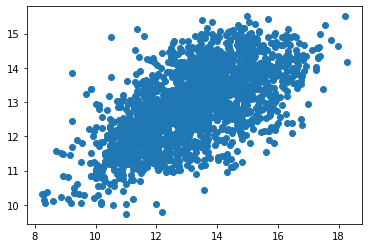

In [184]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,SGDRegressor

X = validX
y = validy

reg = Ridge().fit(trainX, trainy)
y_pred = reg.predict(X)
R2 = reg.score(X,y)

plt.scatter(y,y_pred)
R2

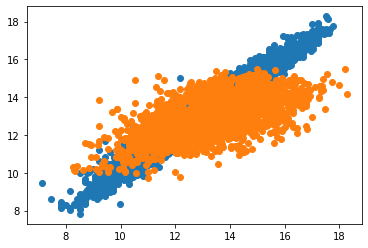

In [140]:

plt.scatter(np.log(medianPrice),np.log(salePrice))
plt.scatter(y,y_pred)

0


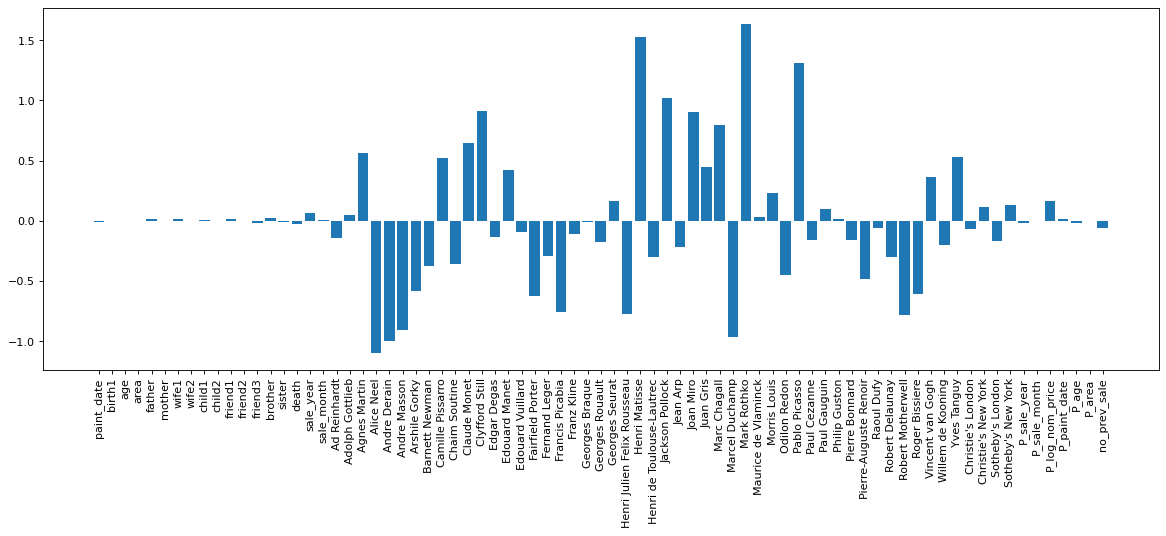

In [185]:
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)
plt.bar(data_proc.iloc[:trainSplit].drop("log_nom_price",axis=1).columns,reg.coef_)
plt.xticks(rotation=90)
print(0)